In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

convert_tensor = transforms.ToTensor()
resize_to_300 = transforms.Resize((300,300))

In [3]:
music_data = {}
keys = ['ambient', 'symphonic', 'country', 'rocknroll','metal' ]
for key in keys:
    music_data[key] = {}
for genre in os.listdir('./Stimuli/'):
    for file in os.listdir('./Stimuli/'+ genre):
        if 'spec' in file:
            path = './Stimuli/'+ genre +'/' + file
            img = convert_tensor(np.array(Image.open(path).convert('L'))[50:450, 100:500])
            spec = img[0]
            music_data[genre][file[0]] = spec


In [4]:
inp = torch.rand(10,1,160,160,36)

In [5]:
num_classes = 5

class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        
        self.conv1 = nn.Sequential(
                nn.Conv3d(1, 16, kernel_size=(7, 7, 7), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
        self.conv2 = nn.Sequential(
                nn.Conv3d(16, 4, kernel_size=(5, 5, 5), padding=1),
                nn.ReLU(),
                nn.MaxPool3d((4, 4, 4)),
                )
        
        self.fc1 = nn.Linear(324, 128)

    
        self.model =  ViT(
                        patch_size=10, 
                        num_layers=3, 
                        h_dim=512, 
                        num_heads=7, 
                        num_classes=128, 
                        d_ff=1024, 
                        max_time_steps=1000, 
                        use_clf_token=True,
                        dropout=0.1,
                        dropout_emb=0.1,
                        channels=1
                    )

    def forward(self, img, brain_volume):
        # Set 1
        out = self.conv1(brain_volume)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        brain_embeds = self.fc1(out)
        music_embeds = self.model(img)
        
        return brain_embeds, music_embeds

In [6]:
from models.vit import ViT

In [7]:
img = torch.rand(24,1,300,300)
b  = torch.rand(24,1,160,160,36)

In [8]:
model = CNN_Classifier()
a,c = model(img, b)
print(a.shape, c.shape)

torch.Size([24, 128]) torch.Size([24, 128])


In [9]:
import os
import nibabel as nib
import pandas as pd

dirname = 'ds000113b_R2.0.1/'
brain_volumes = []
class_labels = []
music = []
classes = ['ambient', 'symphonic', 'country', 'rocknroll','metal' ]
for subj in os.listdir(dirname):
    for run in range(1,9):
        path = dirname+"/"+subj+"/func" + "/" + subj + '_task-auditoryperception_run-0'+ str(run)                     
        img = nib.load(path + '_bold.nii.gz')
        data = img.get_fdata()

        df = pd.read_csv(path + '_events.tsv', sep='\t')
        genres = df['genre'].values
        run_volumes = df['run_volume'].values
        stimuli = df['stim'].values
        for start, genre, stim in zip(run_volumes, genres, stimuli):
            volume = data[:,:,:,start:start+6].mean(axis=-1)
            brain_volumes.append(volume)
            class_labels.append(classes.index(genre))
            music.append(music_data[genre][stim[-5]])
    break

In [10]:
len(brain_volumes), len(class_labels)

(200, 200)

In [11]:
brain_volumes[0].shape

(160, 160, 36)

(160, 160, 36, 153)


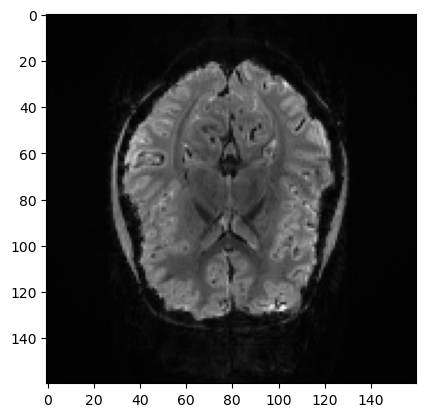

In [12]:
import matplotlib.pyplot as plt
a = brain_volumes[0]
plt.imshow(a[:,:,18].T, cmap='Greys_r')
print(data.shape)

In [13]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np

class BrainDataset(Dataset):
    def __init__(self, brain_volumes, class_labels, music):
        self.brain_volumes = brain_volumes
        self.class_labels = class_labels
        self.music = music

    def __len__(self):
        return len(self.class_labels)

    def __getitem__(self, idx):
        temp_img = brain_volumes[idx]
        ind = np.where(brain_volumes[idx] < 200)
        temp_img[ind] = 0
        temp_img = temp_img / 2200
        return temp_img, self.class_labels[idx], music[idx].resize_(300,300)


In [14]:
music[0].resize_(300,300).shape

torch.Size([300, 300])

In [15]:
# train_len = int(0.8 * len(brain_volumes))
# train_dataset = BrainDataset(brain_volumes[:train_len], class_labels[:train_len])
# val_dataset = BrainDataset(brain_volumes[train_len:], class_labels[train_len:])

dataset = BrainDataset(brain_volumes, class_labels, music)

In [16]:
train_dataset , val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [17]:
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24,shuffle=True)

In [18]:
for i, data in enumerate(train_loader):
    print(data[0].shape)
    print(data[1].shape)
    print(data[2].shape)
    break

torch.Size([24, 160, 160, 36])
torch.Size([24])
torch.Size([24, 300, 300])


tensor(2)


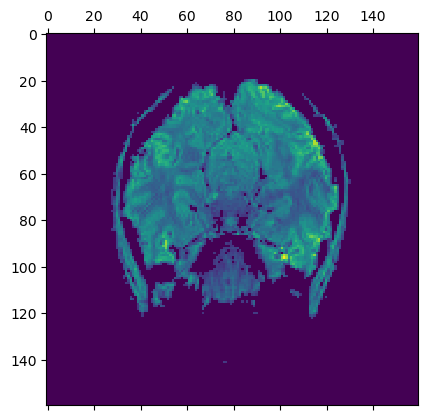

In [19]:
plt.matshow(data[0][0][:,:,6].T)
print(data[1][0])

In [20]:
def train_one_epoch(model, optimizer, dataloader,epoch):
    model.train()
    losses = []
    accs = []
    binaccs = []
    
    for i, (brain_volume, label, music) in enumerate(dataloader):
        optimizer.zero_grad()
        brain_volume = brain_volume.unsqueeze(1)
        
        music = music.unsqueeze(1)
        music = music.double()
        music = music.to(device)
        brain_volume = brain_volume.to(device)
        label = label.to(device)
        
        
        brain_embeds, music_embeds = model(music, brain_volume)
        loss = loss_fn(brain_embeds, music_embeds)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        
        print("Epoch ", epoch,": ", i, "/", len(dataloader), "loss :", loss.item(), end='\r')
    print("train acc", np.mean(accs))
    print("train binary acc", np.mean(binaccs))
    return np.mean(losses), np.mean(accs)

def validate(model, optimizer, dataloader,epoch):
    model.eval()
    losses = []
    accs = []
    binaccs = []
    for i, (brain_volume, label, music) in enumerate(dataloader):
        brain_volume = brain_volume.unsqueeze(1)
        
        music = music.unsqueeze(1)
        music = music.double()
        music = music.to(device)
        brain_volume = brain_volume.to(device)
        label = label.to(device)
         
        brain_embeds, music_embeds = model(music, brain_volume)
        loss = loss_fn(brain_embeds, music_embeds)

        
    print("val acc", np.mean(accs))
    print("val binary acc", np.mean(binaccs))
    
    return np.mean(losses), np.mean(accs)

In [21]:
class CLIPLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, mol_features, spectra_features):
        device = mol_features.device
        logits_per_mol =  mol_features @ spectra_features.t()
        logits_per_spectra =  spectra_features @ mol_features.t()
        
        num_logits = logits_per_mol.shape[0]
        labels = torch.arange(num_logits, device=device)
        
        total_loss = (F.cross_entropy(logits_per_mol, labels) + 
                     F.cross_entropy(logits_per_spectra, labels)
                     ) / 2
        return total_loss

In [22]:
model = CNN_Classifier()
device = torch.device('cuda')
model.to(device)
model.double()

loss_fn = CLIPLoss()


lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
num_epochs = 30
train_losses = []
val_losses = []
val_accs = []
train_accs = []
for epoch in range(num_epochs):
    loss, acc = train_one_epoch(model, optimizer, train_loader, epoch)
    val_loss, val_acc = validate(model, optimizer, val_loader, epoch)
    train_losses.append(loss)
    train_accs.append(acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print("---------------")

train acc nan / 7 loss : 2.7763435510353625
train binary acc nan


/home2/vijay.vignesh/miniconda3/envs/tdl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/vijay.vignesh/miniconda3/envs/tdl/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7748074882050666
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7735803678199547
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7712822748543954
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7714173213907243
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7724218763839312
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7755698030073104
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7698380649147054
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7710901976590536
train binary acc nan
val acc nan
val binary acc nan
---------------
train acc nan / 7 loss : 2.7754014137745833
train binary 

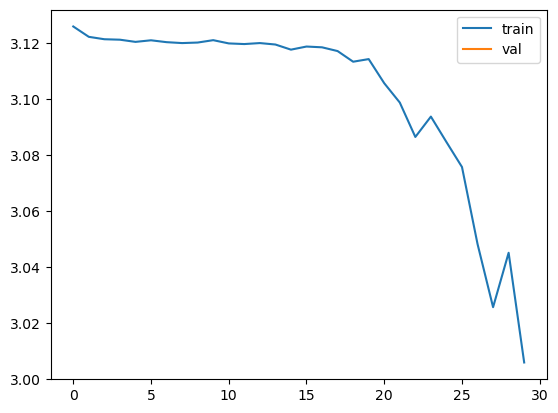

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()

In [24]:
plt.plot(val_accs+0.5, label="val acc")
plt.plot(train_accs, label="train acc")
plt.legend()

TypeError: can only concatenate list (not "float") to list